# Thorough Gridsearch Model


This notebook contains code to easily add a model and preprocessor(s) and gridsearch through every possible combination to find the best

## Future:
Compare bagging, boosting, gradient, with base model.

---

In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from pprint import pprint
from xgboost import XGBClassifier

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Labeler
from util.reddit_functions import plot_confusion_matrix
from util.grid_models import custom_stop_words, get_random_class_labels

In [3]:
labels = get_random_class_labels(8)
print(labels)

df = dataloader.data_selector(labels, data_source='sqlite')

df.sample(10)

['linux' 'datascience' 'etl' 'mongodb' 'apachespark' 'pandas'
 'dataengineering' 'machinelearning']
Connection to SQLite DB successful


,title,subreddit,date
5448,Best way to design Bucketing for Hive table (S...,dataengineering,2020-03-29
16108,[project] BERT and Mark Twain,machinelearning,2020-04-10
2468,Xrdesktop: Linux desktop environments In VR (S...,linux,2020-03-29
930,Parquet conversion and S3,apachespark,2020-03-29
1847,Best way to do user matching on a dating app,mongodb,2020-03-29
2421,Linux’s Marketing Problem,linux,2020-03-29
5164,The Advantages of Using an ETL Platform vs Wri...,etl,2020-03-29
4628,"[D]""Testing the Manifold Hypothesis"" .I'm find...",machinelearning,2020-03-29
4875,🚂 On Track with Apache Kafka – Building a Stre...,etl,2020-03-29
2649,What does /etc/mailname do?,linux,2020-03-29


In [4]:
X = df['title']
y = df['subreddit']

In [5]:
labeler = Labeler()
labeler.fit(y)
y = labeler.transform(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [7]:
tfidf = {
    'preprocessor': TfidfVectorizer(stop_words=custom_stop_words),
    'params': {
        "prep__ngram_range": [(1, 2)],
        "prep__max_df": [.7, .8, .9],
        "prep__use_idf": [True],
        "prep__norm": ["l2"]
    }
}

In [8]:
lr = {
    'clf': LogisticRegression(max_iter=1000),
    'params': {
        "clf__C": [.01, .1, 1, 5]
    }
    
}

In [9]:
mlp = {
    'clf': MLPClassifier(),
    'params': {
        "clf__hidden_layer_sizes": [50, 100, 200]
    }
}

In [10]:
xgb = {
    'clf': XGBClassifier(),
    'params': {
        "clf__hidden_layer_sizes": [10, 25, 50],
        "clf__n_estimators": [50, 100, 200],
        "clf__max_depth": [5, 10, 20]
    }
}

In [11]:
random = {
    'clf': RandomForestClassifier(),
    'params': {
        "clf__n_estimators": [200, 300]
    }
}

In [12]:
onevrest = {
    'clf': OneVsRestClassifier(RandomForestClassifier()),
    'params': {
        "clf__estimator__n_estimators": [200, 300]
    }
}

In [13]:
def build_and_train_model(preprocessor, classifier, cv=3, verbose=1):
    '''
    Takes a dictionary with params and outputs a fitted model
    '''
    pipe = Pipeline(
    [('prep', preprocessor.get('preprocessor')),
     ('clf', classifier.get('clf'))])
    
    pipe_params = dict()
    pipe_params.update(preprocessor.get('params'))
    pipe_params.update(classifier.get('params'))
    
    model = GridSearchCV(pipe, param_grid=pipe_params, cv=cv, verbose=verbose, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   47.5s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   48.0s finished


Train Score: 0.9925075721345449
Test Score: 0.5896700143472023
AUC Score: 0.859923159474695
              precision    recall  f1-score   support

           0      0.607     0.386     0.472        44
           1      0.513     0.519     0.516       235
           2      0.617     0.664     0.640       262
           3      0.760     0.744     0.752       399
           4      0.452     0.344     0.390       285
           5      0.798     0.742     0.769       485
           6      0.314     0.222     0.260        99
           7      0.345     0.507     0.411       282

    accuracy                          0.590      2091
   macro avg      0.551     0.516     0.526      2091
weighted avg      0.601     0.590     0.591      2091



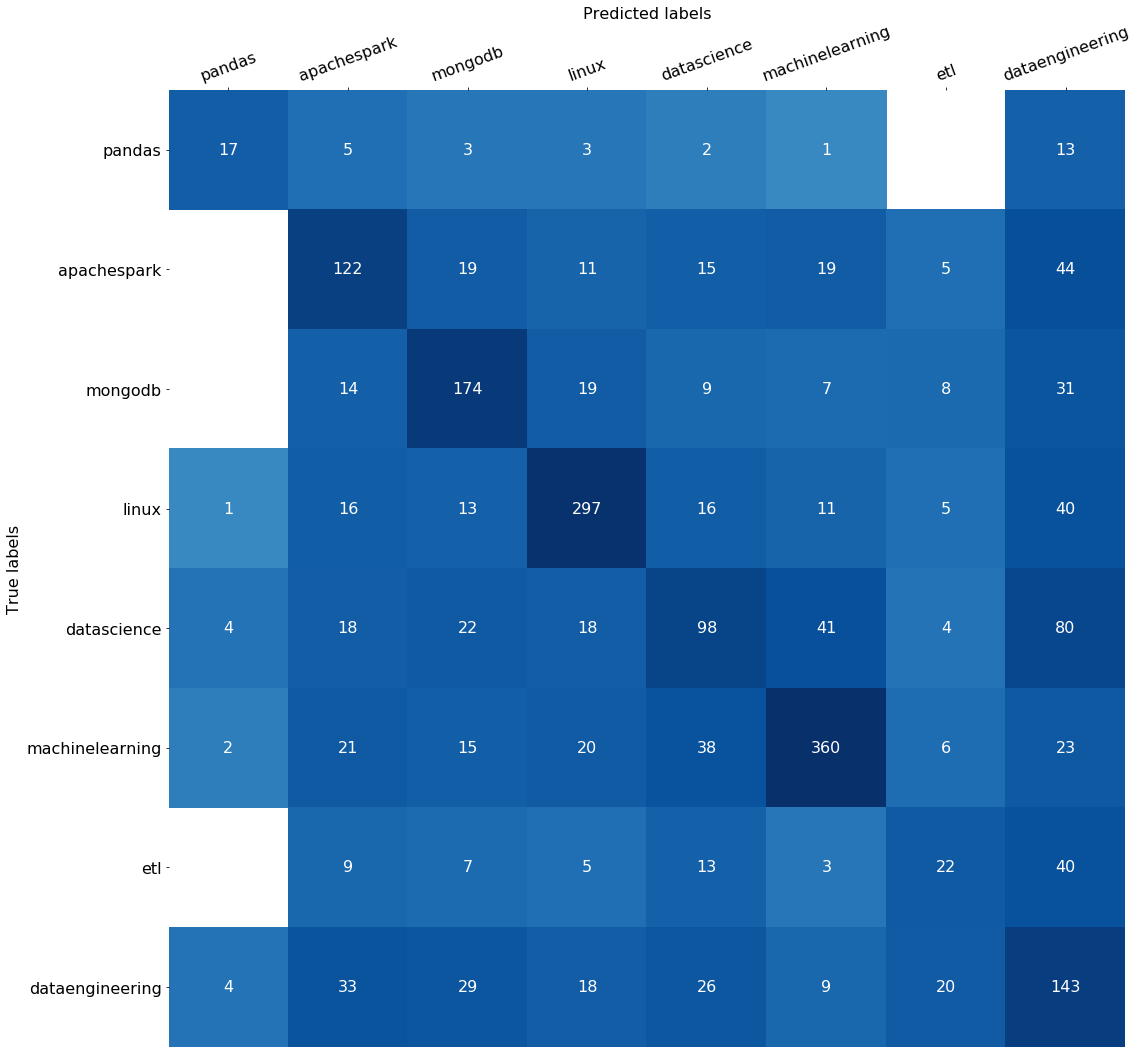

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/chris/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  3.1min remaining:   52.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.1min finished


Train Score: 0.9925075721345449
Test Score: 0.5954088952654233
AUC Score: 0.8600075871909908
              precision    recall  f1-score   support

           0      0.739     0.386     0.507        44
           1      0.523     0.532     0.527       235
           2      0.596     0.710     0.648       262
           3      0.793     0.729     0.760       399
           4      0.451     0.358     0.399       285
           5      0.783     0.751     0.766       485
           6      0.375     0.212     0.271        99
           7      0.345     0.493     0.406       282

    accuracy                          0.595      2091
   macro avg      0.576     0.521     0.536      2091
weighted avg      0.608     0.595     0.596      2091



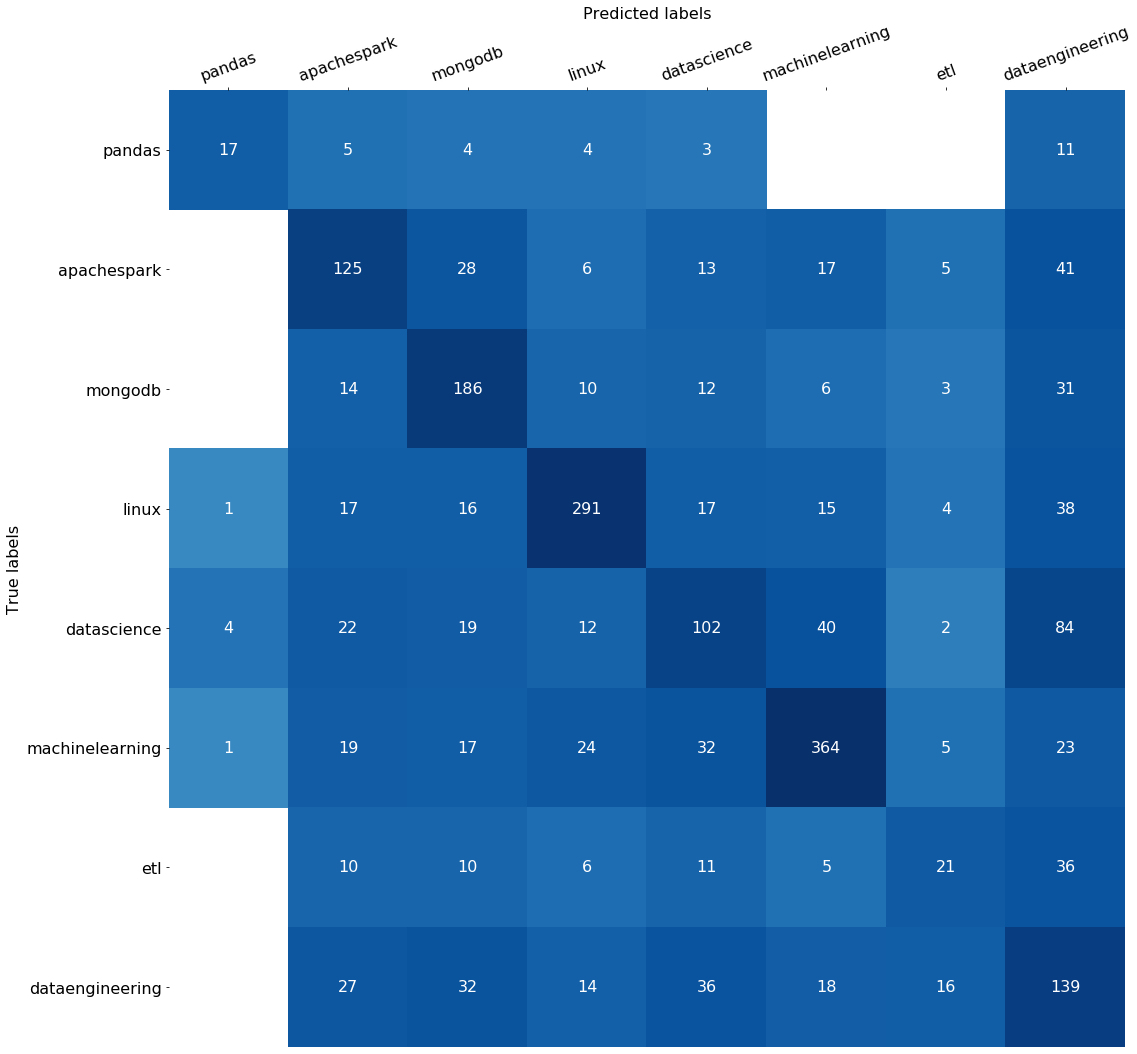

In [14]:
for estimator in [random, onevrest]:
    
    model = build_and_train_model(preprocessor=tfidf, classifier=estimator)
    
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        print(f'AUC Score: {roc_auc_score(y_test, y_proba, multi_class="ovr")}')
        
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

    plot_confusion_matrix(model, y_test, y_pred, classes=labeler.classes_)
    plt.show()